## Photokinetic simulator




In [6]:
#@title Install and Load Packages { display-mode: "form" }

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left to download and import the required packages 
#@markdown in this Colab notebook.

#@markdown **Note**: This installs the sympy package on the Colab 
#@markdown notebook in the cloud and not on your computer.

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import sympy
except ImportError:
    %shell pip install sympy

from sympy import symbols, Symbol
from IPython.display import display, Math
import numpy as np


try:
    import kin_model
except ImportError:
    %shell wget -q "https://raw.githubusercontent.com/dmadea/Photo-Kinetic-Simulator/main/kin_model.py"

from kin_model import PhotoKineticSymbolicModel

In [2]:
#@title Fontsize of the output cells { display-mode: "form", run: "auto" }

#@markdown Set the fontsize of the text in output cells,
#@markdown default value is 18px.

font_size =   18#@param {type:"integer"}

# from https://stackoverflow.com/questions/61957742/how-to-increase-font-size-of-google-colab-cell-output
def increase_font():
    from IPython.display import Javascript
    display(Javascript(f'''
    for (rule of document.styleSheets[0].cssRules){{
        if (rule.selectorText=='body') {{
            rule.style.fontSize = '{font_size}px'
            break
        }}
    }}'''))

if IN_COLAB:
    # set it to run in every cell
    get_ipython().events.register('pre_run_cell', increase_font)
    # disable
    # get_ipython().events.unregister('pre_run_cell', increase_font)

### Input the text model

Use rules as for LaTeX

In [3]:
text_model = """
BR -hv-> ^1BR --> BR          // k_S  # population of singlet state and decay to GS with rate k_S
^1BR --> ^3BR --> BR          // k_{isc} ; k_T
^3BR + ^3O_2 --> ^1O_2 + BR   // k_{TT}
^1O_2 --> ^3O_2               // k_d
^1O_2 + BR --> BR + ^3O_2     // k_q
BR + ^1O_2 -->                // k_r
"""

model = PhotoKineticSymbolicModel.from_text(text_model)
model.print_model()

<IPython.core.display.Math object>

In [4]:
print('\n')
model.pprint_equations()
print('\n')

# # substitute for isc quantum yield
# k_S, k_isc, *_ = model.symbols['rate_constants']
# phi_isc = symbols('\phi_{isc}')
# subs = [(k_isc / (k_isc + k_S), phi_isc)]

model.steady_state_approx(['^1BR', '^3BR', '^1O_2'])  # set the species for SS approximation

Eq(Derivative(c_{BR}(t), t), -J*(1 - 1/10**(epsilon*l*c_{BR}(t))) + k_S*c_{^1BR}(t) + k_T*c_{^3BR}(t) - k_r*c_{BR}(t)*c_{^1O_2}(t) + k_{TT}*c_{^3BR}(t)*c_{^3O_2}(t))

Eq(Derivative(c_{^1BR}(t), t), J*(1 - 1/10**(epsilon*l*c_{BR}(t))) - k_S*c_{^1BR}(t) - k_{isc}*c_{^1BR}(t))

Eq(Derivative(c_{^3BR}(t), t), -k_T*c_{^3BR}(t) - k_{TT}*c_{^3BR}(t)*c_{^3O_2}(t) + k_{isc}*c_{^1BR}(t))

Eq(Derivative(c_{^3O_2}(t), t), k_d*c_{^1O_2}(t) + k_q*c_{BR}(t)*c_{^1O_2}(t) - k_{TT}*c_{^3BR}(t)*c_{^3O_2}(t))

Eq(Derivative(c_{^1O_2}(t), t), -k_d*c_{^1O_2}(t) - k_q*c_{BR}(t)*c_{^1O_2}(t) - k_r*c_{BR}(t)*c_{^1O_2}(t) + k_{TT}*c_{^3BR}(t)*c_{^3O_2}(t))

Eq(Derivative(c_{BR}(t), t), -J*k_r*k_{TT}*k_{isc}*(10**(epsilon*l*c_{BR}(t)) - 1)*c_{BR}(t)*c_{^3O_2}(t)/(10**(epsilon*l*c_{BR}(t))*(k_S + k_{isc})*(k_T + k_{TT}*c_{^3O_2}(t))*(k_d + k_q*c_{BR}(t) + k_r*c_{BR}(t))))

Eq(c_{^1BR}(t), J*(10**(epsilon*l*c_{BR}(t)) - 1)/(10**(epsilon*l*c_{BR}(t))*(k_S + k_{isc})))

Eq(c_{^3BR}(t), J*k_{isc}*(10**(epsilon*l*c_{BR}(t)) - 1)/(10**(epsilon*l*c_{BR}(t))*(k_S + k_{isc})*(k_T + k_{TT}*c_{^3O_2}(t))))

Eq(Derivative(c_{^3O_2}(t), t), -J*k_r*k_{TT}*k_{isc}*(10**(epsilon*l*c_{BR}(t)) - 1)*c_{BR}(t)*c_{^3O_2}(t)/(10**(epsilon*l*c_{BR}(t))*(k_S + k_{isc})*(k_T + k_{TT}*c_{^3O_2}(t))*(k_d + k_q*c_{BR}(t) + k_r*c_{BR}(t))))

Eq(c_{^1O_2}(t), J*k_{TT}*k_{isc}*(10**(epsilon*l*c_{BR}(t)) - 1)*c_{^3O_2}(t)/(10**(epsilon*l*c_{BR}(t))*(k_S + k_{isc})*(k_T + k_{TT}*c_{^3O_2}(t))*(k_d + k_q*c_{BR}(t) + k_r*c_{BR}(t))))

[k_S, k_{isc}, k_T, k_{TT}, k_d, k_q, k_r]


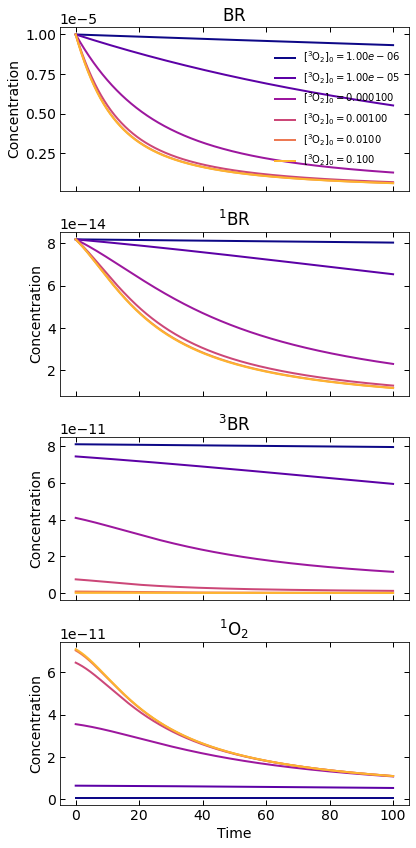

In [27]:
print(model.symbols['rate_constants'])
model.simulate_model([1e9, 1e8, 1e5, 1e9, 1/9.5e-6, 1e4, 1e9], [1e-5, 0, 0, np.logspace(-6, -1, 6), 0],
                         constant_compartments=['^3O_2'], t_max=1e2, yscale='linear', epsilon=1e5, flux=1e-4,
                         plot_separately=True)


In [28]:
str_model = """
Susceptible + Infected --> 2Infected // k_t
Infected --> Recovered    // k_r
Infected --> Dead         // k_d
"""

model = PhotoKineticSymbolicModel.from_text(str_model)

model.print_model()
print('\n')
model.pprint_equations()


<IPython.core.display.Math object>

Eq(Derivative(c_{Susceptible}(t), t), -k_t*c_{Infected}(t)*c_{Susceptible}(t))

Eq(Derivative(c_{Infected}(t), t), -k_d*c_{Infected}(t) - k_r*c_{Infected}(t) + k_t*c_{Infected}(t)*c_{Susceptible}(t))

Eq(Derivative(c_{Recovered}(t), t), k_r*c_{Infected}(t))

Eq(Derivative(c_{Dead}(t), t), k_d*c_{Infected}(t))

[k_t, k_r, k_d]


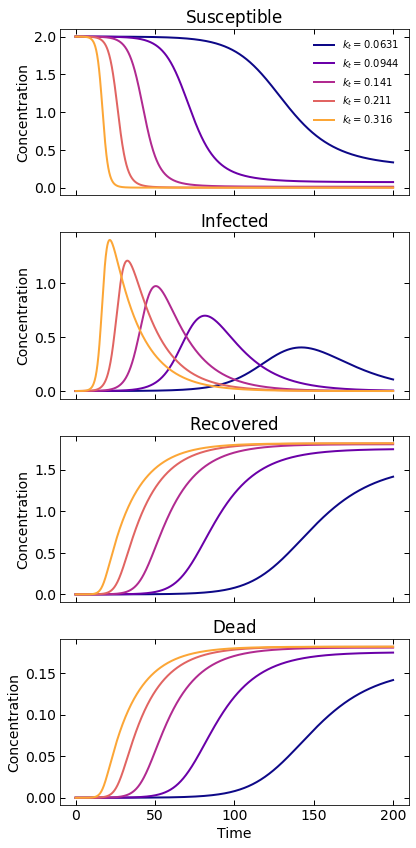

In [34]:
print(model.symbols['rate_constants'])
model.simulate_model([np.logspace(-1.2, -0.5, 5), 0.05, 0.005], [2, 1e-4, 0, 0], t_max=2e2, yscale='linear', plot_separately=True)


In [15]:
str_model = """
ArO_2 --> Ar + ^1O_2             // k_1  # absorption and singlet state decay
^1O_2 --> ^3O_2                  // k_d
# ^1O_2 + Ar --> Ar + ^3O_2         // k_{q,Ar}
# ^1O_2 + ArO_2 --> ArO_2 + ^3O_2     // k_{q,ArO_2}
^1O_2 + S --> S + ^3O_2           // k_{q,S}
S + ^1O_2 -->                      // k_r
"""

model = PhotoKineticSymbolicModel.from_text(str_model)

model.print_model()
print('\n')
# model.pprint_equations()
# print('\n')

model.steady_state_approx(['^1O_2'])  # set the species for SS approximation

<IPython.core.display.Math object>

Eq(Derivative(c_{ArO_2}(t), t), -k_1*c_{ArO_2}(t))

Eq(Derivative(c_{Ar}(t), t), k_1*c_{ArO_2}(t))

Eq(c_{^1O_2}(t), k_1*c_{ArO_2}(t)/(k_d + k_r*c_{S}(t) + k_{q,S}*c_{S}(t)))

Eq(Derivative(c_{^3O_2}(t), t), k_1*(k_d + k_{q,S}*c_{S}(t))*c_{ArO_2}(t)/(k_d + k_r*c_{S}(t) + k_{q,S}*c_{S}(t)))

Eq(Derivative(c_{S}(t), t), -k_1*k_r*c_{ArO_2}(t)*c_{S}(t)/(k_d + k_r*c_{S}(t) + k_{q,S}*c_{S}(t)))

[k_1, k_d, k_{q,S}, k_r]


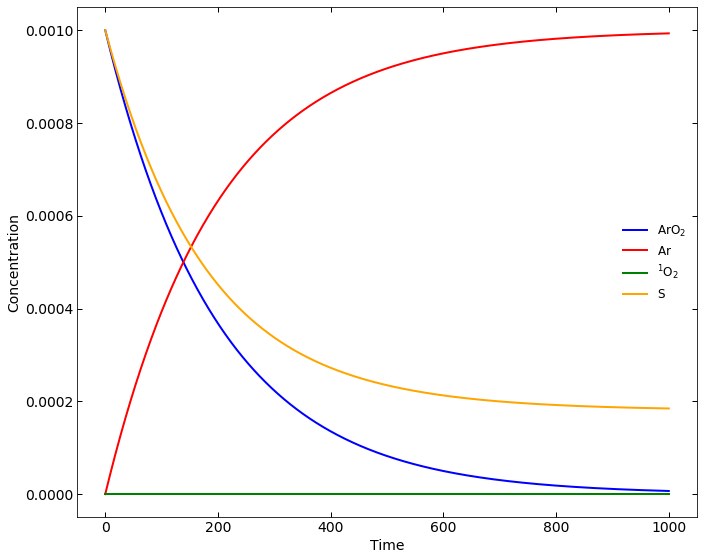

In [17]:
print(model.symbols['rate_constants'])
model.simulate_model([5e-3, 1/9.5e-6, 1e4, 1e9], [1e-3, 0, 0, 0, 1e-3], constant_compartments=['^3O_2'], t_max=1e3, yscale='linear', scale=True, figsize=(10, 8),
plot_separately=False)